---
date: 2021-07-23
tags:
- python
---

# Covid in NSW, 2021 edition

work in progress, just wanted to see the nsw covid numbers all in one graph.

In [1]:
import datetime

# viz stuff
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
from numpy.polynomial import Polynomial

# import plotly.express as px
# import plotly.graph_objects as go

## NSW data

https://data.nsw.gov.au/nsw-covid-19-data

### Total covid cases

Modify this to start from first date.

[covidlive](https://covidlive.com.au/report/daily-source-overseas/nsw) gives the total local cases - the **net** column is the local cases only.

In [2]:
def get_total_cases(start_date: str="27 June 2021"):
    """gets total local cases"""
    start_date = pd.to_datetime(start_date, dayfirst=True)
    
    df = pd.read_html("https://covidlive.com.au/report/daily-source-overseas/nsw")[1]

    df.columns = df.columns.str.title()  # hate caps
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)  # need dates
    df = df.query("Date >= @start_date")  # only want dates for current spread

    df = df.sort_values(by="Date", ignore_index=True)  # sorted properly

    df = df[["Date", "Net", "Net2"]]
    df = df.rename(columns={"Net": "Local_cases", "Net2": "Overseas_cases"})
    return df

df_total = get_total_cases()
print(df_total.shape)
df_total.tail(3)

(31, 3)


,Date,Local_cases,Overseas_cases
28,2021-07-25,141,0
29,2021-07-26,145,6
30,2021-07-27,172,3


### Wild Cases

In [14]:
from datetime import datetime

In [15]:
def get_wild_cases():
    """returns df of infectious cases in the community"""
    try:
        df = pd.read_html("https://covidlive.com.au/report/daily-wild-cases/nsw")[1]
    except:
        print(f"something went wrong trying to access the data")
        return False
        
    df.columns = df.columns.str.title()  # hate caps
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)  # need dates
    df = df.sort_values(by="Date", ignore_index=True)  # sorted properly
    
    row = df.iloc[-1] 
    if any(row[["Full", "Part", "Unkn"]] == "-"):
        print(f"{row.Date:%d %b} is being updated")
        
    return df

df_wild = get_wild_cases()
print(df_wild.shape)
df_wild.tail(3)

(31, 6)


,Date,Full,Part,Unkn,Total,Iso
28,2021-07-25,38,24,14,76,46%
29,2021-07-26,51,25,11,87,40%
30,2021-07-27,60,19,32,111,35%


### Final data

This is the dataset I'm using to make graphs prediction etc.

For smoothing, see [this](https://towardsdatascience.com/five-wrong-ways-to-do-covid-19-data-smoothing-1538db6ff182).

In [16]:
def get_data():
    """returns cleaned and joined data"""
    df_wild = get_wild_cases()
    df_total = get_total_cases()
    
    assert df_wild.shape[0] == df_total.shape[0]
    
    df = pd.merge(df_wild, df_total, on=["Date"])
    df["Isolating"] = df.Local_cases - df.Total
    
    # some stats
    for col in ["Full", "Part", "Unkn", "Total", "Isolating", "Local_cases"]:
        # exponential weighted avg
        df[f"{col}_ewa"] = df[col].ewm(span=7, adjust=False).mean()

        # rolling mean, though ideally add some forward prediction
        df[f"{col}_roll"] = df[col].rolling(7, center=True, min_periods=4).mean()
        
    return df

df = get_data()
print(df.shape)
df.tail(3)

(31, 21)


,Date,Full,Part,Unkn,Total,Iso,Local_cases,Overseas_cases,Isolating,Full_ewa,...,Part_ewa,Part_roll,Unkn_ewa,Unkn_roll,Total_ewa,Total_roll,Isolating_ewa,Isolating_roll,Local_cases_ewa,Local_cases_roll
28,2021-07-25,38,24,14,76,46%,141,0,65,39.515698,...,19.344065,22.166667,13.221584,17.666667,72.081347,89.0,54.090697,56.0,126.172044,145.0
29,2021-07-26,51,25,11,87,40%,145,6,58,42.386773,...,20.758049,22.200000,12.666188,17.800000,75.811010,89.4,55.068022,59.8,130.879033,149.2
30,2021-07-27,60,19,32,111,35%,172,3,61,46.790080,...,20.318537,23.500000,17.499641,19.000000,84.608258,91.0,56.551017,63.0,141.159275,154.0


## Graphs

First up, to eyeball what is happening

In [17]:
def get_label(col):
    if "_roll" in col:
        col = col.split("_roll")[0]
        
    labels = {
        "Full": "Fully infectious\n(Glady's number)",
        "Part": "Partly infections WTF",
        "Unkn": "Unknown, or we don't know",
        "Total": "Infectious in the community\n(real number)",
        "Local_cases": "All cases\nisolating + infectious",
        "Isolating": "iso All cases, isolating + infectious"
    }
    
    return labels[col]

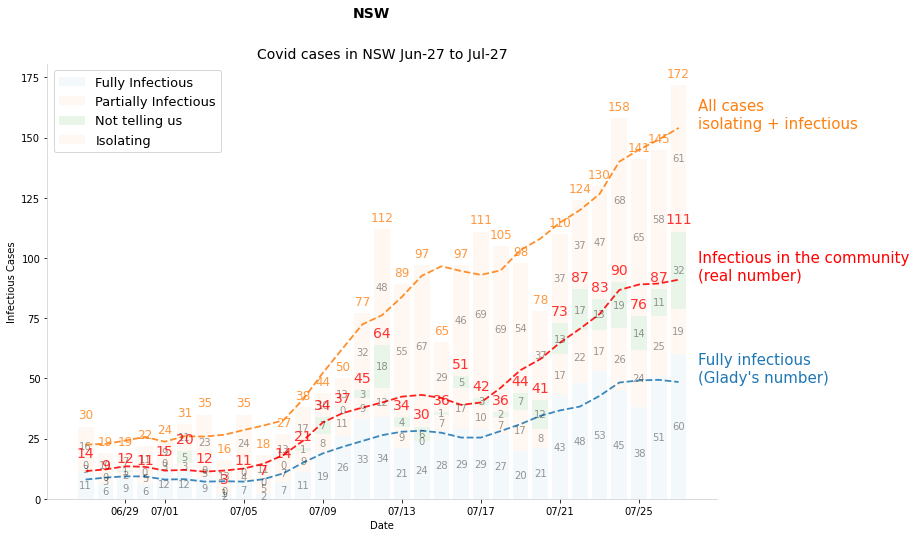

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("NSW")
ax.set_title(
    f"Covid cases in NSW {df.Date.min():%b-%d} to {df.Date.max():%b-%d}",
    fontsize=14)

ax.set_ylabel("Infectious Cases")
ax.set_xlabel("Date")

X = df.Date
colors = {}

# draw smoothed lines
cols=["Local_cases", "Total", "Full"]
for i, col in enumerate(cols[::-1]):
    Y = df[col]
    Y_roll = df[f"{col}_roll"]
    bottom = None if (i-1)<0 else df[cols[i-1]]

    # draw line
    line = ax.plot(X, Y_roll,
        lw=1.8, linestyle="--", alpha=0.88,
        color = "red" if col == "Total" else None)

    color = line[0].get_color()
    colors[col] = color

    # label line at its end
    xy = X.iloc[-1] + pd.DateOffset(days=1), Y_roll.values[-1]
    ax.annotate(get_label(col), xy=xy, fontsize=15,
                color=color)

# step
#ax.step(df.Date, df.Total, "o--", alpha=0.35, color=colors["Total"])    

# stacked bar chart
alpha=0.05
full = ax.bar(df.Date, df.Full, label="Fully Infectious", alpha=alpha)
part = ax.bar(df.Date, df.Part, bottom=df.Full, label="Partially Infectious", alpha=alpha)
unkn = ax.bar(df.Date, df.Unkn, bottom=df.Full + df.Part, label="Not telling us", alpha=0.1)
isolating = ax.bar(df.Date, df.Isolating, bottom=df.Total, label="Isolating",
           color=colors["Local_cases"], alpha=alpha) # only drawing for labels

for rect in [full, part, unkn, isolating]: # label the bars in the center
    ax.bar_label(rect, label_type='center', alpha=0.4)

# label totals by making a invisible total bar 
r = ax.bar(df.Date, df.Total, alpha=0) # only drawing for labels
ax.bar_label(r, alpha=0.8, padding=5, fontsize=14, color=colors["Total"])

ax.bar_label(isolating, alpha=0.8, padding=5, fontsize=12, color=colors["Local_cases"])

# final plot tweaks
date_form = mdates.DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.legend(loc="upper left", fontsize=13)


plt.show()

## Extrapolation

Now to use a simple fit to extend cases out 5 days.

In [628]:
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
from sklearn import linear_model

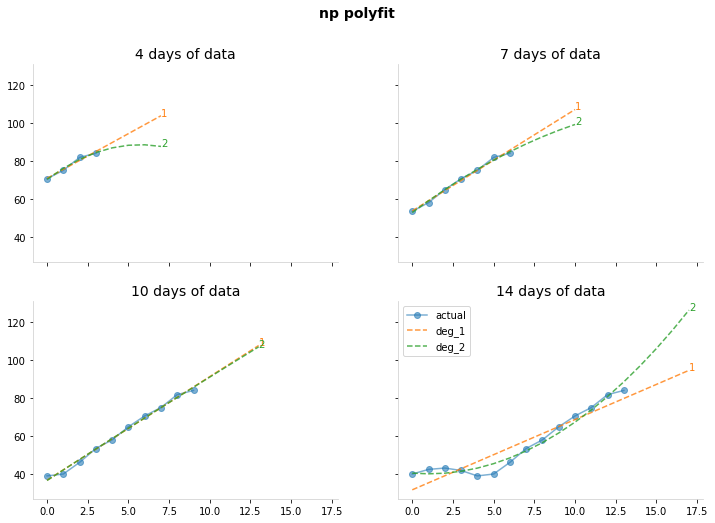

In [629]:
DEG = 2
DAYS = 10
FORECAST = 5 # num of days to look ahead

fig, axs = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle("np polyfit")

for ax, DAYS in zip(axs.flat, [4, 7, 10, 14]):
    y = df.tail(DAYS).Total_roll.values
    x = np.arange(len(y))
    xx = np.arange(max(x)+FORECAST)
    
    ax.set_title(f"{DAYS} days of data")
    ax.plot(x, y, "o-", label="actual", alpha=0.58)
    
    for DEG in [1,2]:
        p = Polynomial.fit(x, y, DEG)
        line = ax.plot(xx, p(xx), "--", label=f"deg_{DEG}", alpha=0.8
                      )
        ax.annotate(f"{DEG}", xy=(xx[-1], p(xx)[-1]), 
                    color=line[0].get_color())
    
ax.legend();

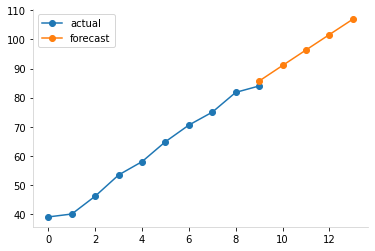

In [630]:
DEG = 2
DAYS = 10
FORECAST = 5 # num of days to look ahead

y = y = df.tail(DAYS).Total_roll.values
x = np.arange(len(y))
xx = np.arange(max(x), max(x)+FORECAST)
p = Polynomial.fit(x, y, DEG)

plt.plot(x, y, "o-", label = "actual")
plt.plot(xx, p(xx), "o-", label="forecast")
plt.legend();

## A simple R calculation

R estimate: 1.26


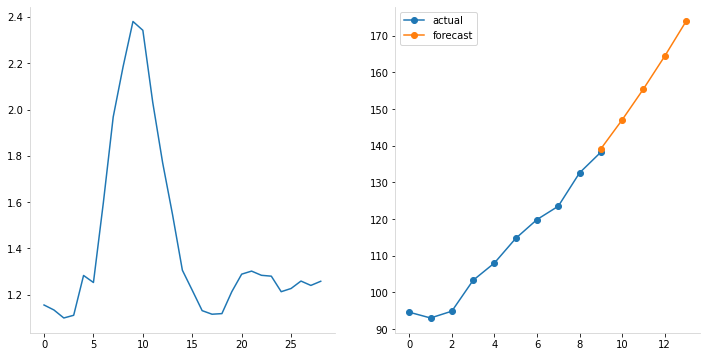

1.2580412233938458

In [674]:
def get_R(col:str = "Total_roll", T=5):
    """col: column to look at
       T: doubling time"""
    
    DEG = 2
    DAYS = 10
    FORECAST = 5 # num of days to look ahead

    y = y = df.tail(DAYS).Local_cases_roll.values
    x = np.arange(len(y))
    xx = np.arange(max(x), max(x)+FORECAST)
    p = Polynomial.fit(x, y, DEG)

    cases = np.concatenate((df[col].values, p(xx)))

    r = (cases[T:] / cases[:-T])
    R = r[-1]
    print(f"R estimate: {R:.2f}")

    fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,6))
    ax.plot(r)
    
    ax1.plot(x, y, "o-", label = "actual")
    ax1.plot(xx, p(xx), "o-", label="forecast")
    ax1.legend()
    plt.show()

    return R

get_R("Local_cases_roll")

In [687]:
def predict(col="Total_roll"):
    start_date = df.Date.iloc[-1]
    end_date = start_date + pd.DateOffset(days=15)
    #end_date = pd.to_datetime("15 December 2021", dayfirst=True)
    x_future = pd.date_range(start_date, end_date, freq=pd.DateOffset(days=1))

    c = df[col].values[-1]
    y_pred = [c * (R**(t/T)) for t in np.arange(1, len(x_future)+1)]
    y_pred[0] = df[col].values[-1] # to make the plot pretty

    y_high = [c * (R*1.2)**(t/T) for t in np.arange(1, len(x_future)+1)]
    y_low = [c * (R*0.80)**(t/T) for t in np.arange(1, len(x_future)+1)]
    print(col, len(x_future), len(y_low), len(y_pred), len(y_high))
    return y_low, y, y_high
    
_ = predict("Total_roll")

Total_roll 16 16 16 16


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

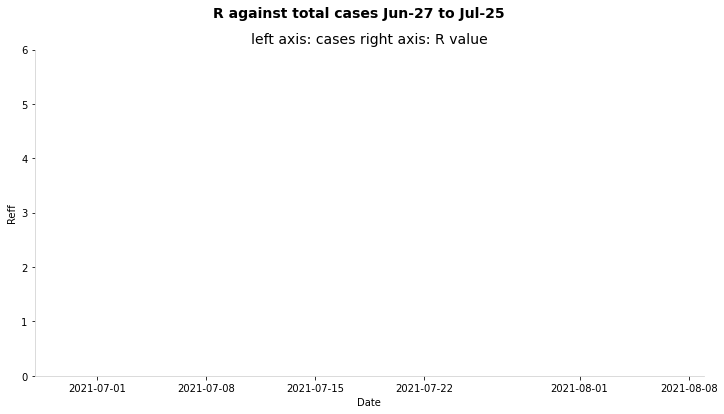

In [688]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle(
    f"R against total cases {df.Date.min():%b-%d} to {df.Date.max():%b-%d}")
ax.set_title(
    f"left axis: cases right axis: R value")

ax2.set_ylabel("Infectious Cases")
ax.set_xlabel("Date")
ax.axis(xmin=min(df.Date), xmax=max(x_future))

# plot R on first axis
ax.set_ylim([0,6])
ax.set_ylabel("Reff")
ax.fill_between(df.Date, r, np.zeros_like(r), label="R", alpha=0.07)
ax.legend()

# plot cases on right y axis
ax2 = ax.twinx()
ax2.set_yscale("log")
ax2.set_ylabel("Infectious Cases")

act = ax2.step(df.Date, df.Total, alpha=0.16, color="red", label="Infectious cases")

# smoothing lines
ax2.plot(df.Date, df.Total_roll, label="Infectious cases smoothed",
       linewidth=1.5, linestyle="-", color="red", alpha=0.5)

# projection
for col in ["Total_roll", "Local_cases_roll"]:
    x_future = pd.date_range(start_date, end_date, freq=pd.DateOffset(days=1))
    print(len(x_future))
    y_low, y_pred, y_high = predict(col)
    print(len(x_future), len(y_low), len(y_pred), len(y_high))
    #ax2.plot(x_future, y_pred, "--", color="red", label=f"{col} projection")
    ax2.plot(x_future, y_low, "--", alpha = 0.1)
    ax2.plot(x_future, y_high, "--", alpha = 0.1)
    ax2.fill_between(x_future, y_pred_plus, y_pred_minus, 
                    color="red", alpha=0.05, label="Uncertainity")

ax2.legend();

16
Total_roll 16 16 16 16
Total_roll 16 16 10 16


ValueError: x and y must have same first dimension, but have shapes (16,) and (10,)

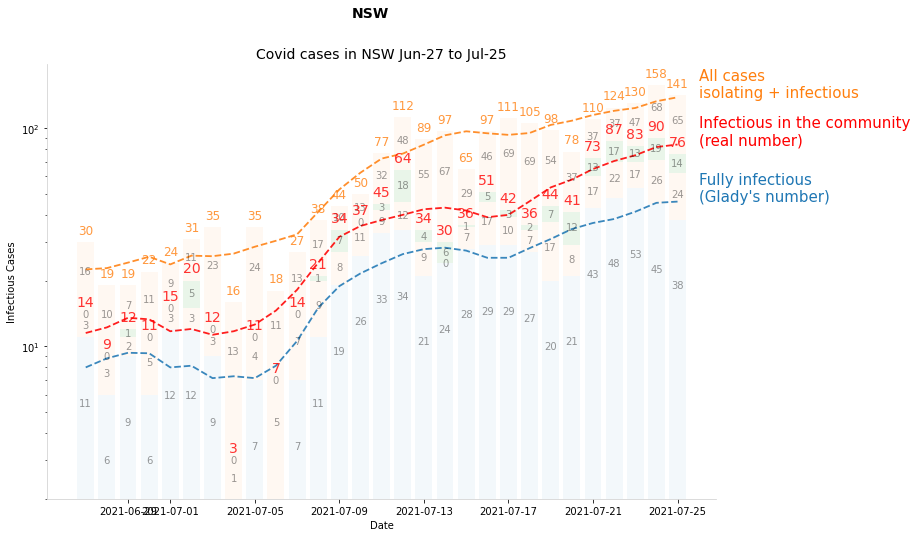

In [689]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("NSW")
ax.set_title(
    f"Covid cases in NSW {df.Date.min():%b-%d} to {df.Date.max():%b-%d}",
    fontsize=14)

ax.set_ylabel("Infectious Cases")
ax.set_xlabel("Date")

X = df.Date
colors = {}

# draw smoothed lines
cols=["Local_cases", "Total", "Full"]
for i, col in enumerate(cols[::-1]):
    Y = df[col]
    Y_roll = df[f"{col}_roll"]
    bottom = None if (i-1)<0 else df[cols[i-1]]

    # draw line
    line = ax.plot(X, Y_roll,
        lw=1.8, linestyle="--", alpha=0.88,
        color = "red" if col == "Total" else None)

    color = line[0].get_color()
    colors[col] = color

    # label line at its end
    xy = X.iloc[-1] + pd.DateOffset(days=1), Y_roll.values[-1]
    ax.annotate(get_label(col), xy=xy, fontsize=15,
                color=color)

# step
#ax.step(df.Date, df.Total, "o--", alpha=0.35, color=colors["Total"])    

# stacked bar chart
alpha=0.05
full = ax.bar(df.Date, df.Full, label="Fully Isolating", alpha=alpha)
part = ax.bar(df.Date, df.Part, bottom=df.Full, label="Partially Isolating", alpha=alpha)
unkn = ax.bar(df.Date, df.Unkn, bottom=df.Full + df.Part, label="Not telling us", alpha=0.1)
isolating = ax.bar(df.Date, df.Isolating, bottom=df.Total, label="Isolating",
           color=colors["Local_cases"], alpha=alpha) # only drawing for labels

for rect in [full, part, unkn, isolating]: # label the bars in the center
    ax.bar_label(rect, label_type='center', alpha=0.4)

# label totals by making a invisible total bar 
r = ax.bar(df.Date, df.Total, alpha=0) # only drawing for labels
ax.bar_label(r, alpha=0.8, padding=5, fontsize=14, color=colors["Total"])

ax.bar_label(isolating, alpha=0.8, padding=5, fontsize=12, color=colors["Local_cases"])


# projection
ax.set_yscale("log")
for col, c in zip(["Total_roll", "Local_cases_roll"], ("red", "orange")):
    x_future = pd.date_range(start_date, end_date, freq=pd.DateOffset(days=1))
    print(len(x_future))
    y_low, y_pred, y_high = predict(col)
    print(col, len(x_future), len(y_low), len(y_pred), len(y_high))
    ax.plot(x_future, y_pred, "--", color="red", label=f"{col} projection")
    ax.plot(x_future, y_low, "--", alpha = 0.1)
    ax.plot(x_future, y_high, "--", alpha = 0.1)
    ax.fill_between(x_future, y_low, y_high, 
                    color=c, alpha=0.02, label="Uncertainity")


# final plot tweaks
date_form = mdates.DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.legend(loc="upper left", fontsize=13)


plt.show()

Note: fix this right now it is way too simple

## SIR Model TODO

This has 4 states:

- S: susceptible
- E: Exposed
- I: Infected
- R: Removed (recovered or dead, assumed to be immune either way)

the states progress: `s -> E -> I -> R`

In [325]:
from scipy.integrate import odeint

In [363]:
pop_size = 8.16e6
pop_sydney = 5.36e6
f"NSW: {pop_size:,} Greater Sydney: {pop_sydney:,}"

'NSW: 8,160,000.0 Greater Sydney: 5,360,000.0'

In [337]:
# fixed parameters, from observations in the real world
recovery_rate = 1 / 18   # γ, avg illness duration
infection_rate = 1 / 5.2 # σ, avg incubation period

In [262]:
vax_date = pd.to_datetime("15 December 2021", dayfirst=True)
V1 = 0.34
V2 = 0.14

X = pd.date_range(start_date, vax_date, freq=pd.DateOffset(days=1))